# Projet 4 : Anticipez les besoins en consommation électrique de bâtiments

## Notebook 2 : Modélisation (SiteEnergyUse(kBtu))

In [1]:
# Chargement des librairies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Algorithmes simples
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from sklearn.svm import LinearSVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

# Algorithmes ensemblistes
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor

# Utiles
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyRegressor
from sklearn.pipeline import Pipelineine

# Normalisation
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import make_pipeline

# Scoring
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from sklearn.compose import make_column_transformer

In [2]:
# Commençons par charger les données :
data = pd.read_csv("2016_Building_Energy_Benchmarking3.csv")
print('Le jeu des données data compte {} colonnes et {} lignes.'.format(
    data.shape[1], data.shape[0]))

Le jeu des données data compte 37 colonnes et 1645 lignes.


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1645 entries, 0 to 1644
Data columns (total 37 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    1645 non-null   int64  
 1   DataYear                         1645 non-null   int64  
 2   BuildingType                     1645 non-null   object 
 3   PrimaryPropertyType              1645 non-null   object 
 4   PropertyName                     1645 non-null   object 
 5   Address                          1645 non-null   object 
 6   ZipCode                          1645 non-null   float64
 7   CouncilDistrictCode              1645 non-null   int64  
 8   Neighborhood                     1645 non-null   object 
 9   Latitude                         1645 non-null   float64
 10  Longitude                        1645 non-null   float64
 11  NumberofBuildings                1645 non-null   float64
 12  NumberofFloors      

In [4]:
data

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,ZipCode,CouncilDistrictCode,Neighborhood,Latitude,...,NaturalGas(kBtu),ComplianceStatus,TotalGHGEmissions,BuildingAge,SteamUse_check,Electricity_check,NaturalGas_check,LP_Ratio,SLP_Ratio,TLP_Ratio
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,98101.0,7,DOWNTOWN,47.61220,...,1276453.0,Compliant,249.98,89,1,1,1,100,0,0
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,98101.0,7,DOWNTOWN,47.61317,...,5145082.0,Compliant,295.86,20,0,1,1,81,15,4
2,3,2016,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,98101.0,7,DOWNTOWN,47.61393,...,1493800.0,Compliant,2089.28,47,1,1,1,79,0,0
3,5,2016,NonResidential,Hotel,HOTEL MAX,620 STEWART ST,98101.0,7,DOWNTOWN,47.61412,...,1811213.0,Compliant,286.43,90,1,1,1,100,0,0
4,8,2016,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),401 LENORA ST,98121.0,7,DOWNTOWN,47.61375,...,8803998.0,Compliant,505.01,36,0,1,1,70,39,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1640,50069,2016,NonResidential,Small- and Mid-Sized Office,Airport - Main Terminal,7277 Perimeter Rd.,98108.0,2,GREATER DUWAMISH,47.53161,...,2253621.0,Compliant,134.80,87,0,1,1,100,0,0
1641,50070,2016,NonResidential,Other,Tennis Center Sand Point,7135 Sportsfield Drive NE,98155.0,4,NORTHEAST,47.68109,...,1024160.0,Compliant,67.65,3,0,1,1,100,0,0
1642,50081,2016,NonResidential,K-12 School,Hamlin Robinson School,1701 20th Ave South,98144.0,3,GREATER DUWAMISH,47.58831,...,0.0,Compliant,9.24,1,0,1,0,102,0,0
1643,50094,2016,NonResidential,Mixed Use Property,AIBS,601 Westlake Ave N.,98109.0,7,LAKE UNION,47.62497,...,15727308.0,Compliant,1000.06,1,0,1,1,44,31,24


## 1. Preprocessing

In [1]:
identity = [
    'OSEBuildingID',
    'PropertyName',
]

features_cat = [
    'PrimaryPropertyType'
]

features_num = [
    'NumberofBuildings',
    'PropertyGFATotal',
    'PropertyGFABuilding(s)',
    'LargestPropertyUseTypeGFA',
    'SecondLargestPropertyUseTypeGFA',
    'ZipCode',
    'SteamUse_check',
    'NaturalGas_check',
    'Electricity_check',
    'LP_Ratio',
    'SLP_Ratio',
    'TLP_Ratio',
]

features_high_corr = [
    'SteamUse(kBtu)', 'NaturalGas(kBtu)', 'Electricity(kBtu)'
]

to_predict = ['SiteEnergyUse(kBtu)', 'TotalGHGEmissions']

energystar = ['ENERGYSTARScore']

## 1.1 Standardisation et encodage des features

In [37]:
column_trans = make_column_transformer(
    (OneHotEncoder(), features_cat),  # encodage
    (StandardScaler(), features_num),  # standardisation
    #(StandardScaler(), features_high_corr),
    remainder='passthrough')

y = data['SiteEnergyUse(kBtu)'].values

X = column_trans.fit_transform(data[features_cat + features_num])

In [38]:
X[1]

array([ 0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        , -0.05771794, -0.0528873 , -0.06235224, -0.05466449,
       -0.07099222, -0.85996687, -0.27287568,  0.63528231,  0.07820619,
       -0.19958427,  0.16192461,  0.29445842])

In [39]:
X.shape

(1645, 33)

## 1.2. Echantillonnage

Faisons l'echantillonnage. Split du dataset en 2 parties :

- Données d’entrainement 
- Données de test

In [40]:
# Séparons nos données en un jeu de test et un jeu d'entraînement :
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, test_size=0.2, random_state = 42)  # 20% des données dans le jeu de test

print(f"La taille de données d'entrainement : {X_train.shape[0]}")
print(f"La taille de données d'entrainement : {X_test.shape[0]}")

La taille de données d'entrainement : 1316
La taille de données d'entrainement : 329


In [41]:
X

array([[ 0.        ,  0.        ,  1.        , ...,  0.42142185,
        -0.71620499, -0.35052707],
       [ 0.        ,  0.        ,  1.        , ..., -0.19958427,
         0.16192461,  0.29445842],
       [ 0.        ,  0.        ,  1.        , ..., -0.26495334,
        -0.71620499, -0.35052707],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.48679091,
        -0.71620499, -0.35052707],
       [ 0.        ,  0.        ,  0.        , ..., -1.40891198,
         1.09859618,  3.51938585],
       [ 0.        ,  0.        ,  0.        , ...,  0.45410638,
        -0.71620499, -0.35052707]])

## 2. Les modèles testés

In [42]:
def score(modele, R2, RMSE, MAE, time, df_scores):
    df_scores.loc[df_scores.shape[0]] = [modele, R2, RMSE, MAE, time]
    df_scores.sort_values(by='R2', ascending=False, inplace=True)
    df_scores.drop_duplicates(subset=['modele'], keep='last', inplace=True)
    df_scores.reset_index(drop=True, inplace=True)
    return df_scores

In [43]:
scores = []

df_scores_1 = pd.DataFrame(
    scores, columns=['modele', 'R2', 'RMSE', 'MAE', 'time'])

## 2.1. Modèle 1: Linear Regression

In [44]:
standard_scaler = preprocessing.StandardScaler().fit(X_train)

X_train = standard_scaler.transform(X_train)
X_test = standard_scaler.transform(X_test)

lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
y_pred_lr = lin_reg.predict(X_test)

In [45]:
# Prediction score :
print("R^2 : {:.4f}".format(r2_score(y_test, y_pred_lr)))

R^2 : 0.7366


In [46]:
parametres_LR = {}

# On crée un modèle de régression linéaire
# On entraîne ce modèle sur les données d'entrainement
grid_LR = GridSearchCV(LinearRegression(),
                       parametres_LR,
                       scoring='r2',
                       cv=5)
modele_LR = grid_LR.fit(X_train, y_train)
y_pred_LR = grid_LR.predict(X_test)

In [47]:
# Affichage des scores
r2_LR = r2_score(y_test, y_pred_LR)
rmse_LR = round(np.sqrt(metrics.mean_squared_error(y_test, y_pred_LR)), 3)
mae_LR = round(np.sqrt(metrics.median_absolute_error(y_test, y_pred_LR)), 3)
time_LR = round(grid_LR.cv_results_['mean_fit_time'].max(), 3)

# Les meilleur parametres
print(grid_LR.best_params_)

# Ajoute à la liste des scores
score('Linear Regression', r2_LR, rmse_LR, mae_LR,  time_LR, df_scores_1)

{}


,modele,R2,RMSE,MAE,time
0,Linear Regression,0.736627,1.178431e+07,1597.547,0.004


## 2.2. Modèle 2: Lasso

In [48]:
parametres_Lasso = {}

# On entraîne ce modèle sur les données d'entrainement
grid_Lasso = GridSearchCV(Lasso(), parametres_Lasso, cv=5)
modele_Lasso = grid_Lasso.fit(X_train, y_train)
y_pred_Lasso = grid_Lasso.predict(X_test)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.154773071104014e+16, tolerance: 131688302311397.38
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.0088805539248856e+16, tolerance: 119837672418515.56
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.773457548460096e+16, tolerance: 128496963745229.22
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: C

In [49]:
# Affichage des scores
r2_Lasso = round(r2_score(y_test, y_pred_Lasso), 3)
rmse_Lasso = round(np.sqrt(metrics.mean_squared_error(y_test, y_pred_Lasso)), 3)
mae_Lasso = round(np.sqrt(metrics.median_absolute_error(y_test, y_pred_Lasso)), 3)
time_Lasso = round(grid_Lasso.cv_results_['mean_fit_time'].max(), 3)
# Les meilleur parametres
print(grid_Lasso.best_params_)

# Ajoute à la liste des scores
score('Lasso', r2_Lasso, rmse_Lasso, mae_Lasso,  time_Lasso, df_scores_1)

{}


,modele,R2,RMSE,MAE,time
0,Linear Regression,0.736627,1.178431e+07,1597.547,0.004
1,Lasso,0.736000,1.179202e+07,1597.881,0.035


## 2.3. Modèle 3: Ridge

In [50]:
parametres_Ridge = {}

# On entraîne ce modèle sur les données d'entrainement
grid_Ridge = GridSearchCV(Ridge(), parametres_Ridge, cv=5)
grid_Ridge.fit(X_train, y_train)
y_pred_Ridge = grid_Ridge.predict(X_test)

In [51]:
# Affichage des scores
r2_Ridge = round(r2_score(y_test, y_pred_Ridge), 3)
rmse_Ridge = round(np.sqrt(metrics.mean_squared_error(y_test, y_pred_Ridge)), 3)
mae_Ridge = round(np.sqrt(metrics.median_absolute_error(y_test, y_pred_Ridge)), 3)
time_Ridge = round(grid_Ridge.cv_results_['mean_fit_time'].max(), 3)

# Les meilleur parametres
print(grid_Ridge.best_params_)

# Ajoute à la liste des scores
score('Ridge', r2_Ridge, rmse_Ridge, mae_Ridge, time_Ridge, df_scores_1)

{}


,modele,R2,RMSE,MAE,time
0,Ridge,0.738000,1.174816e+07,1579.833,0.003
1,Linear Regression,0.736627,1.178431e+07,1597.547,0.004
2,Lasso,0.736000,1.179202e+07,1597.881,0.035


## 2.4. Modèle 4: ElasticNet Regression

In [52]:
parameters_EN = {
    "max_iter": [1000],
    "tol": [0.5],
    "alpha": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
    "l1_ratio": np.arange(0.0, 1.0, 0.1)
}

# On entraîne ce modèle sur les données d'entrainement
grid_EN = GridSearchCV(ElasticNet(), parameters_EN, cv=5)
grid_EN.fit(X_train, y_train)
y_pred_EN = grid_EN.predict(X_test)

In [53]:
# Affichage des scores
r2_EN = round(r2_score(y_test, y_pred_EN), 3)
rmse_EN = round(np.sqrt(metrics.mean_squared_error(y_test, y_pred_EN)), 3)
mae_EN = round(np.sqrt(metrics.median_absolute_error(y_test, y_pred_EN)), 3)
time_EN = round(grid_EN.cv_results_['mean_fit_time'].max(), 3)

# Les meilleur parametres
print(grid_EN.best_params_)

# Ajoute à la liste des scores
score('Elastic Net', r2_EN, rmse_EN, mae_EN, time_EN, df_scores_1)

{'alpha': 1, 'l1_ratio': 0.0, 'max_iter': 1000, 'tol': 0.5}


,modele,R2,RMSE,MAE,time
0,Ridge,0.738000,1.174816e+07,1579.833,0.003
1,Linear Regression,0.736627,1.178431e+07,1597.547,0.004
2,Lasso,0.736000,1.179202e+07,1597.881,0.035
3,Elastic Net,0.616000,1.422100e+07,1453.151,0.002


## 2.5. Modèle 5: Support Vector Regression


In [54]:
parameters_SVR = {'C': [1000, 10000]}

# On entraîne ce modèle sur les données d'entrainement
grid_SVR = GridSearchCV(LinearSVR(), parameters_SVR, cv=5)
grid_SVR.fit(X_train, y_train)
y_pred_SVR = grid_SVR.predict(X_test)

In [55]:
# Affichage des scores
r2_SVR = round(r2_score(y_test, y_pred_SVR), 3)
rmse_SVR = round(np.sqrt(metrics.mean_squared_error(y_test, y_pred_SVR)), 3)
mae_SVR = round(np.sqrt(metrics.median_absolute_error(y_test, y_pred_SVR)), 3)
time_SVR = round(grid_SVR.cv_results_['mean_fit_time'].max(), 3)

# Les meilleur parametres
print(grid_SVR.best_params_)

# Ajoute à la liste des scores
score('SVR', r2_SVR, rmse_SVR, mae_SVR, time_SVR, df_scores_1)

{'C': 10000}


,modele,R2,RMSE,MAE,time
0,Ridge,0.738000,1.174816e+07,1579.833,0.003
1,Linear Regression,0.736627,1.178431e+07,1597.547,0.004
2,Lasso,0.736000,1.179202e+07,1597.881,0.035
3,Elastic Net,0.616000,1.422100e+07,1453.151,0.002
4,SVR,0.210000,2.040832e+07,1001.576,0.003


## 2.6. Modèle 6: k-Nearest Neighbors


In [56]:
parametres_kNN = {
    'n_neighbors': np.arange(1, 30),
    'metric': ['euclidean', 'manhattan', 'minkowski']
    
}

# On entraîne ce modèle sur les données d'entrainement
grid_KNN = GridSearchCV(KNeighborsRegressor(), parametres_kNN, cv=5)
grid_KNN.fit(X_train, y_train)
y_pred_KNN = grid_KNN.predict(X_test)

In [57]:
# Affichage des scores
r2_KNN = round(r2_score(y_test, y_pred_KNN), 3)
rmse_KNN = round(np.sqrt(metrics.mean_squared_error(y_test, y_pred_KNN)), 3)
mae_KNN = round(np.sqrt(metrics.median_absolute_error(y_test, y_pred_KNN)), 3)
time_KNN = round(grid_KNN.cv_results_['mean_fit_time'].max(), 3)

# Les meilleur parametres
print(grid_KNN.best_params_)

# Ajoute à la liste des scores
score('K Neighbors Regressor', r2_KNN, rmse_KNN, mae_KNN, time_KNN, df_scores_1)

{'metric': 'euclidean', 'n_neighbors': 3}


,modele,R2,RMSE,MAE,time
0,Ridge,0.738000,1.174816e+07,1579.833,0.003
1,Linear Regression,0.736627,1.178431e+07,1597.547,0.004
2,Lasso,0.736000,1.179202e+07,1597.881,0.035
3,Elastic Net,0.616000,1.422100e+07,1453.151,0.002
4,K Neighbors Regressor,0.545000,1.548909e+07,1233.758,0.001
5,SVR,0.210000,2.040832e+07,1001.576,0.003


## 2.7. Modèle 7: Decision Tree

In [58]:
parameters_DT = {
    "max_depth": [1, 3, 5, 7, 9, 11, 12],
    "max_features": ["auto", "log2", None],
}

# On entraîne ce modèle sur les données d'entrainement
grid_DT = GridSearchCV(DecisionTreeRegressor(random_state = 42), parameters_DT, cv=5)
grid_DT.fit(X_train, y_train)
y_pred_DT = grid_DT.predict(X_test)

In [59]:
# Affichage des scores
r2_DT = round(r2_score(y_test, y_pred_DT), 3)
rmse_DT = round(np.sqrt(metrics.mean_squared_error(y_test, y_pred_DT)), 3)
mae_DT = round(np.sqrt(metrics.median_absolute_error(y_test, y_pred_DT)), 3)
time_DT = round(grid_DT.cv_results_['mean_fit_time'].max(), 3)

# Les meilleur parametres
print(grid_DT.best_params_)

# Ajoute à la liste des scores
score('Decision Tree Regressor', r2_DT, rmse_DT, mae_DT, time_DT, df_scores_1)

{'max_depth': 5, 'max_features': 'log2'}


,modele,R2,RMSE,MAE,time
0,Decision Tree Regressor,0.802000,1.022694e+07,1961.977,0.005
1,Ridge,0.738000,1.174816e+07,1579.833,0.003
2,Linear Regression,0.736627,1.178431e+07,1597.547,0.004
3,Lasso,0.736000,1.179202e+07,1597.881,0.035
4,Elastic Net,0.616000,1.422100e+07,1453.151,0.002
5,K Neighbors Regressor,0.545000,1.548909e+07,1233.758,0.001
6,SVR,0.210000,2.040832e+07,1001.576,0.003


## 2. 8. Modèle 8: Random Forest Regressor

In [60]:
parameters_RF = {
    "max_depth": [1, 3, 5, 7, 9, 11, 12],
    "max_features": ["auto", "log2", None],
    "min_samples_leaf":[1,2,4]
}

# On entraîne ce modèle sur les données d'entrainement
grid_RF = GridSearchCV(RandomForestRegressor(), parameters_RF, cv=5)
grid_RF.fit(X_train, y_train)
y_pred_RF = grid_RF.predict(X_test)

In [61]:
# Affichage des scores
r2_RF = round(r2_score(y_test, y_pred_RF), 3)
rmse_RF = round(np.sqrt(metrics.mean_squared_error(y_test, y_pred_RF)), 3)
mae_RF = round(np.sqrt(metrics.median_absolute_error(y_test, y_pred_RF)), 3)
time_RF = round(grid_RF.cv_results_['mean_fit_time'].max(), 3)

# Les meilleur parametres
print(grid_RF.best_params_)

# Ajoute à la liste des scores
score('Random Forest Regressor', r2_RF, rmse_RF, mae_RF, time_RF, df_scores_1)

{'max_depth': 12, 'max_features': 'log2', 'min_samples_leaf': 1}


,modele,R2,RMSE,MAE,time
0,Decision Tree Regressor,0.802000,1.022694e+07,1961.977,0.005
1,Ridge,0.738000,1.174816e+07,1579.833,0.003
2,Linear Regression,0.736627,1.178431e+07,1597.547,0.004
3,Lasso,0.736000,1.179202e+07,1597.881,0.035
4,Elastic Net,0.616000,1.422100e+07,1453.151,0.002
5,Random Forest Regressor,0.607000,1.440373e+07,1255.858,0.362
6,K Neighbors Regressor,0.545000,1.548909e+07,1233.758,0.001
7,SVR,0.210000,2.040832e+07,1001.576,0.003


## 2.9. Modèle 9: Gradient Boosting Regressor

In [62]:
parameters_XG = {
    "max_depth": [1, 3, 5, 7, 9, 11, 12],
    "max_features": ["auto", "log2", None],
}

# On entraîne ce modèle sur les données d'entrainement
grid_XG = GridSearchCV(GradientBoostingRegressor(random_state = 42), parameters_XG, cv=5)
grid_XG.fit(X_train, y_train)
y_pred_XG = grid_XG.predict(X_test)

In [63]:
# Affichage des scores
r2_XG = round(r2_score(y_test, y_pred_XG), 3)
rmse_XG = round(np.sqrt(metrics.mean_squared_error(y_test, y_pred_XG)), 3)
mae_XG = round(np.sqrt(metrics.median_absolute_error(y_test, y_pred_XG)), 3)
time_XG = round(grid_XG.cv_results_['mean_fit_time'].max(), 3)

# Les meilleur parametres
print(grid_XG.best_params_)

# Ajoute à la liste des scores
score('Gradient Boosting Regressor', r2_XG, rmse_XG, mae_XG, time_XG, df_scores_1)

{'max_depth': 7, 'max_features': 'log2'}


,modele,R2,RMSE,MAE,time
0,Decision Tree Regressor,0.802000,1.022694e+07,1961.977,0.005
1,Ridge,0.738000,1.174816e+07,1579.833,0.003
2,Linear Regression,0.736627,1.178431e+07,1597.547,0.004
3,Lasso,0.736000,1.179202e+07,1597.881,0.035
4,Gradient Boosting Regressor,0.629000,1.397918e+07,1132.154,0.466
5,Elastic Net,0.616000,1.422100e+07,1453.151,0.002
6,Random Forest Regressor,0.607000,1.440373e+07,1255.858,0.362
7,K Neighbors Regressor,0.545000,1.548909e+07,1233.758,0.001
8,SVR,0.210000,2.040832e+07,1001.576,0.003


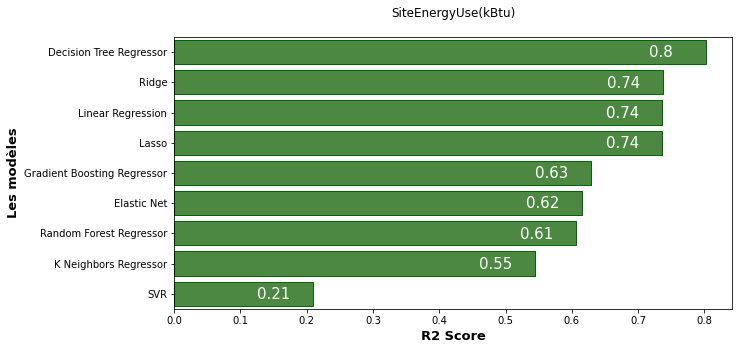

In [64]:
plt.figure(figsize=(10, 5))
plt.title('SiteEnergyUse(kBtu)', pad=20)
col_hist = sns.barplot(x=df_scores_1['R2'],
                       y=df_scores_1['modele'],
                       edgecolor='darkgreen',
                       color='#459436') 
plt.ylabel('Les modèles', size=13, weight='bold')
plt.xlabel('R2 Score', size=13, weight='bold')
for p in col_hist.patches:
    col_hist.annotate(format(round(p.get_width(),2)),
                      (p.get_width() - 0.1, p.get_y() + 0.1 + p.get_height()),
                      color='#ffffff',
                      fontsize=15,
                      xytext=(10, 10),
                      textcoords='offset points')

plt.show()